<p><a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/SMT_SBO_EGO_application.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a></p>

<div class="jumbotron text-left"><b>
    
This tutorial  describes how to use perform Optimization on a direct function or based on a surrogate model (adaptive process or not) and compare the number of functions evaluations on a simple example.

    SMT toolbox is used to build the surrogate model and  performs Bayesian Optimization (EGO method). 
    
    Scipy is used for optimization algorithms (SLSQP, COBYLA).
<div>
    
Rémy PRIEM, Nathalie BARTOLI and Paul SAVES ONERA/DTIS/M2CI 
    
    August  2024 - `SMT version 2.6.3`

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

<div class="alert alert-info fade in" id="d110">
<p>In this notebook, a 1D function ($xsinx$) is minimized</p>
<ol> - using directly a gradient based (SLSQP) or gradient free (COBYLA) algorithm on the true function - multistart technique or not
</ol>
<ol> - using  Surrogate Model  with gradient based (SLSQP) or gradient free (COBYLA) algorithms in an adaptive process or not </ol>    
 <ol> - using  Bayesian Optimization (EGO) where the Surrogate model is used (both mean and variance predictions are considered) </ol>     
</div>

In [1]:
!pip install smt

In [2]:
# import functions
from scipy.optimize import minimize
from smt.sampling_methods import Random
from smt.surrogate_models import KRG, QP

import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
# to avoid warning messages
import warnings

warnings.filterwarnings("ignore")

## Define the 1D function

<IPython.core.display.Javascript object>


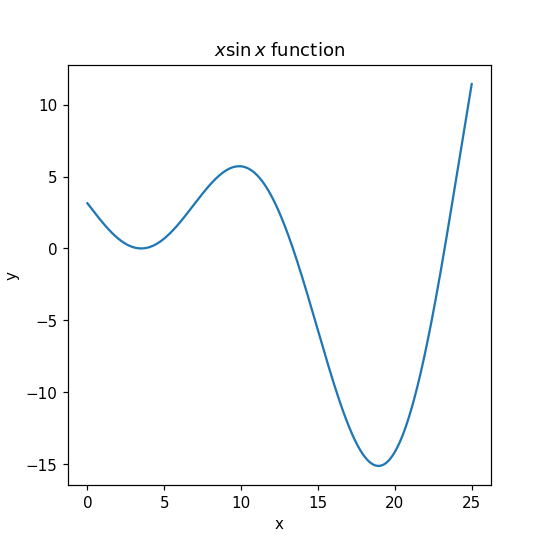

In [4]:
# 1D function to minimize for illustration


def fun_1d(point):
    return np.atleast_2d((point - 3.5) * np.sin((point - 3.5) / (np.pi)))


xlimits = np.array([[0, 25]])

X_plot = np.atleast_2d(np.linspace(xlimits[0, 0], xlimits[0, 1], 10000)).T
Y_plot = fun_1d(X_plot)


lines = []
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
lines.append(true_fun)
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# dimension of the problem
ndim = 1

## Minimize the true function 

with SLSQP or COBYLA algorithms

In [5]:
bnds = ((xlimits[0, 0], xlimits[0, 1]),)
# random value between the two limits
x0 = (xlimits[0, 1] - xlimits[0, 0]) * np.random.random_sample() + xlimits[0, 0]
print("Initial x0 = ", x0)
res = minimize(fun_1d, x0, method="SLSQP", bounds=bnds)
print(res)
xref = res.x
fref = res.fun
neval = res.nfev
print(
    "The reference solution with SLSQP is ",
    xref,
    " obtained with ",
    neval,
    "function evaluations",
)

Initial x0 =  12.08161561653274
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -15.125103236441465
       x: [ 1.894e+01]
     nit: 6
     jac: [-5.126e-06]
    nfev: 14
    njev: 6
The reference solution with SLSQP is  [18.9352085]  obtained with  14 function evaluations


<IPython.core.display.Javascript object>


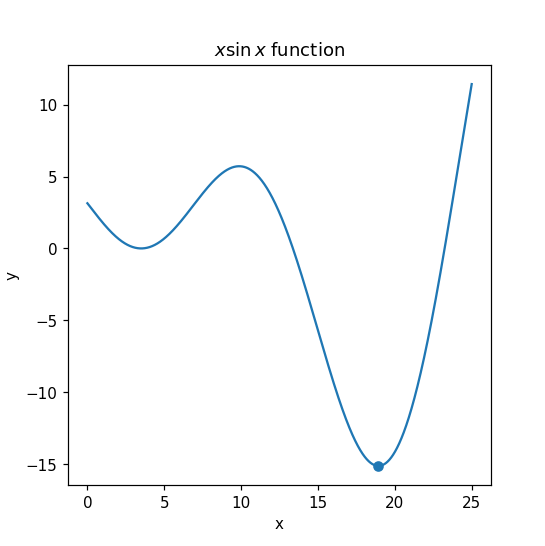

In [6]:
lines = []
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
lines.append(true_fun)
ax.scatter(xref, fref)
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

<IPython.core.display.Javascript object>


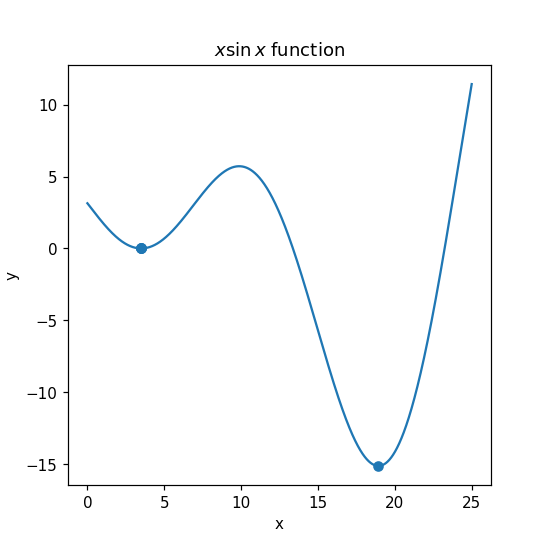

The reference min with SLSQP is [18.93520897]


In [7]:
# try different x0
sampling = Random(xlimits=xlimits)
num = 5
x0list = sampling(num)
sollist = []
funlist = []
for i in range(num):
    x0 = x0list[i]
    res = minimize(fun_1d, x0, method="SLSQP", bounds=bnds)
    sollist.append(res.x)
    funlist.append(res.fun)
lines = []
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
lines.append(true_fun)
ax.scatter(sollist, funlist)
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()
fref = min(funlist)
xref = sollist[funlist.index(fref)]
print("The reference min with SLSQP is", xref)

In [8]:
bnds = ((xlimits[0, 0], xlimits[0, 1]),)
# random value between the two limits
x0 = (xlimits[0, 1] - xlimits[0, 0]) * np.random.random_sample() + xlimits[0, 0]
print("Initial x0 = ", x0)
res = minimize(fun_1d, x0, method="COBYLA", bounds=bnds)
print(res)
xref2 = res.x
fref2 = res.fun
neval2 = res.nfev
print(
    "The reference solution with COBYLA is ",
    xref2,
    " obtained with ",
    neval2,
    "function evaluations",
)

Initial x0 =  24.769131804213114
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -15.125103221135243
       x: [ 1.894e+01]
    nfev: 30
   maxcv: 0.0
The reference solution with COBYLA is  [18.93534743]  obtained with  30 function evaluations


## Create a first Design of Experiments (DOE) to train the surrogate model

Here, the training data are the points of the design of experiments=[0,7,25]. 


In [9]:
xdoe = np.atleast_2d([0, 7, 25]).T
ydoe = fun_1d(xdoe)
n_doe = xdoe.shape[0]
print("Number of DOE points = ", n_doe)

Number of DOE points =  3


# Surrogate model optimization

## Different surrogate models can be trained: 
- Polynomial approximation (Linear or Quadratic approximation)
- Radial Basis function 
- Kriging (or Gaussian Process)
- ....

### Build the a quadratic model  knowing $(x_{doe}, y_{doe})$.

___________________________________________________________________________
   
                                    QP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0007777
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0004661
   
   Prediction time/pt. (sec) :  0.0000000
   


<IPython.core.display.Javascript object>


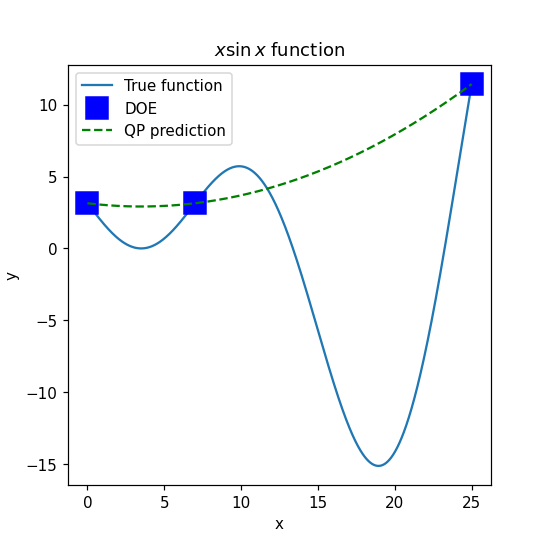

In [10]:
########### The quadratic model
t = QP()
# Training
t.set_training_values(xdoe, ydoe)
t.train()


# Prediction of the  points for the plot
Y_QP_plot = t.predict_values(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(qp,) = ax.plot(X_plot, Y_QP_plot, linestyle="--", color="g")
lines = [true_fun, doe, qp]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(lines, ["True function", "DOE", "QP prediction"])
plt.show()

### Build the GP model (mean prediction and variance) with a square exponential kernel with SMT toolbox knowing $(x_{doe}, y_{doe})$.

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1456308


<IPython.core.display.Javascript object>


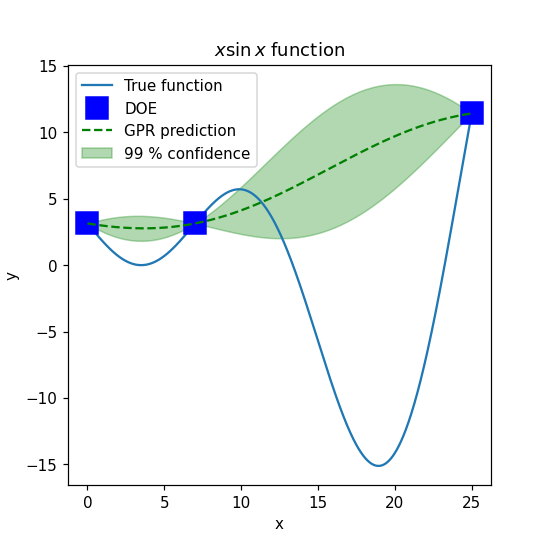

In [11]:
########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2] * ndim, print_prediction=False, corr="squar_exp")

# Training
t.set_training_values(xdoe, ydoe)
t.train()


# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
lines = [true_fun, doe, gp, un_gp]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(lines, ["True function", "DOE", "GPR prediction", "99 % confidence"])
plt.show()

### From this surrogate model (QP, GP, ...) we can define two functions: the mean prediction and the derivative prediction

In [12]:
# function to predict values
def fun_sm(x, t):
    y = t.predict_values(x)
    return y


# function to predict derivatives
def fun_sm_der(x, t):
    kx = 0  # only 1 variable
    y0 = t.predict_derivatives(x, kx)
    return y0

## Optimization done (SLSQP or COBYLA) directly on this surrogate model (build offline)

In [13]:
bnds = ((0, 25),)
res1 = minimize(
    fun_sm, x0, args=t, method="SLSQP", bounds=bnds
)  # We can change to 'COBYLA'
print(res)
x1 = res1.x
f1 = res1.fun
neval1 = res1.nfev
print(
    "The SLSQP solution is ",
    x1,
    " obtained with ",
    neval1,
    "function evaluations of the surrogate model",
)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -15.125103221135243
       x: [ 1.894e+01]
    nfev: 30
   maxcv: 0.0
The SLSQP solution is  [3.66750211]  obtained with  16 function evaluations of the surrogate model


<IPython.core.display.Javascript object>


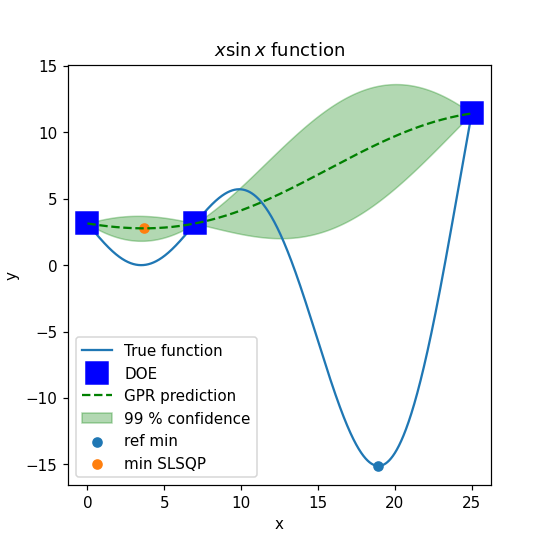

In [14]:
# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
solref = ax.scatter(xref, fref)
sol1 = ax.scatter(x1, f1)

lines = [true_fun, doe, gp, un_gp, solref, sol1]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(
    lines,
    [
        "True function",
        "DOE",
        "GPR prediction",
        "99 % confidence",
        "ref min",
        "min SLSQP",
    ],
)
plt.show()

<IPython.core.display.Javascript object>


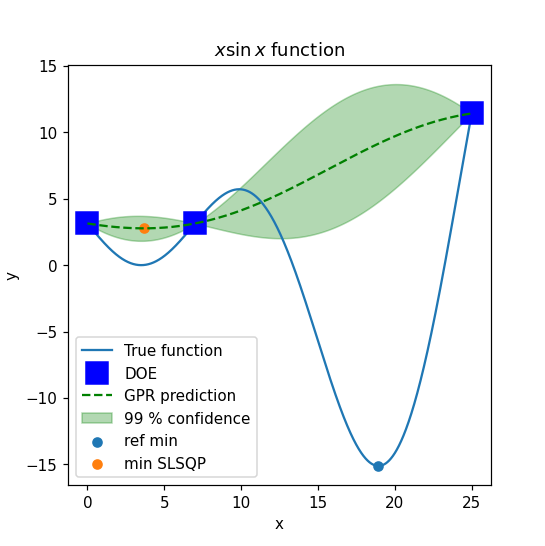

In [15]:
# if we try diffrent x0

sol1list = []
fun1list = []
for i in range(num):
    x0 = x0list[i]
    res1 = minimize(fun_sm, x0, args=t, method="SLSQP", bounds=bnds)
    sol1list.append(res1.x)
    fun1list.append(res1.fun)
f1 = min(fun1list)
x1 = sol1list[fun1list.index(f1)]

# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
solref = ax.scatter(xref, fref)
sol1 = ax.scatter(x1, f1)

lines = [true_fun, doe, gp, un_gp, solref, sol1]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(
    lines,
    [
        "True function",
        "DOE",
        "GPR prediction",
        "99 % confidence",
        "ref min",
        "min SLSQP",
    ],
)
plt.show()

### Optimization with SLSQP (gradient based) using the derivative from the surrogate model

In [16]:
# if we provide the derivative of the surrogate model (jacobian information to provide)

bnds = ((0, 25),)
res1der = minimize(
    fun_sm,
    x0,
    args=t,
    method="SLSQP",
    bounds=bnds,
    jac=fun_sm_der,
    options={"gtol": 1e-6, "disp": True},
)
print(res)
x1der = res1der.x
f1der = res1der.fun
neval1 = res1der.nfev
print(
    "The SLSQP solution is ",
    x1der,
    " obtained with ",
    neval1,
    "function evaluations of the surrogate model",
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7723283220132404
            Iterations: 8
            Function evaluations: 8
            Gradient evaluations: 8
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -15.125103221135243
       x: [ 1.894e+01]
    nfev: 30
   maxcv: 0.0
The SLSQP solution is  [3.66519894]  obtained with  8 function evaluations of the surrogate model


<IPython.core.display.Javascript object>


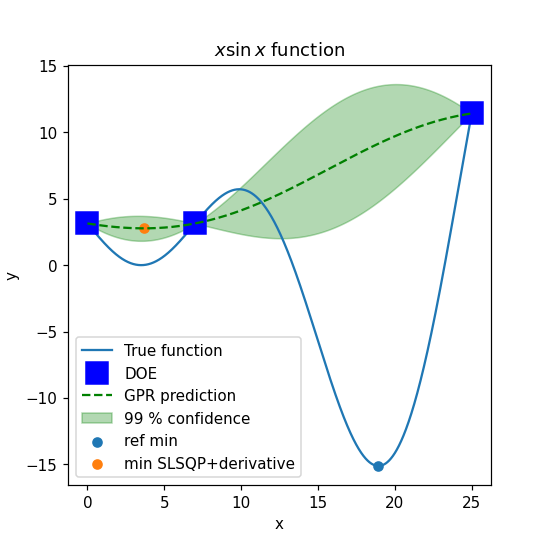

In [17]:
# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
solref = ax.scatter(xref, fref)
sol1 = ax.scatter(x1der, f1der)

lines = [true_fun, doe, gp, un_gp, solref, sol1]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(
    lines,
    [
        "True function",
        "DOE",
        "GPR prediction",
        "99 % confidence",
        "ref min",
        "min SLSQP+derivative",
    ],
)
plt.show()

# Adaptive surrogate model to optimize

Initial DOE [[ 0]
 [ 7]
 [25]]


<IPython.core.display.Javascript object>


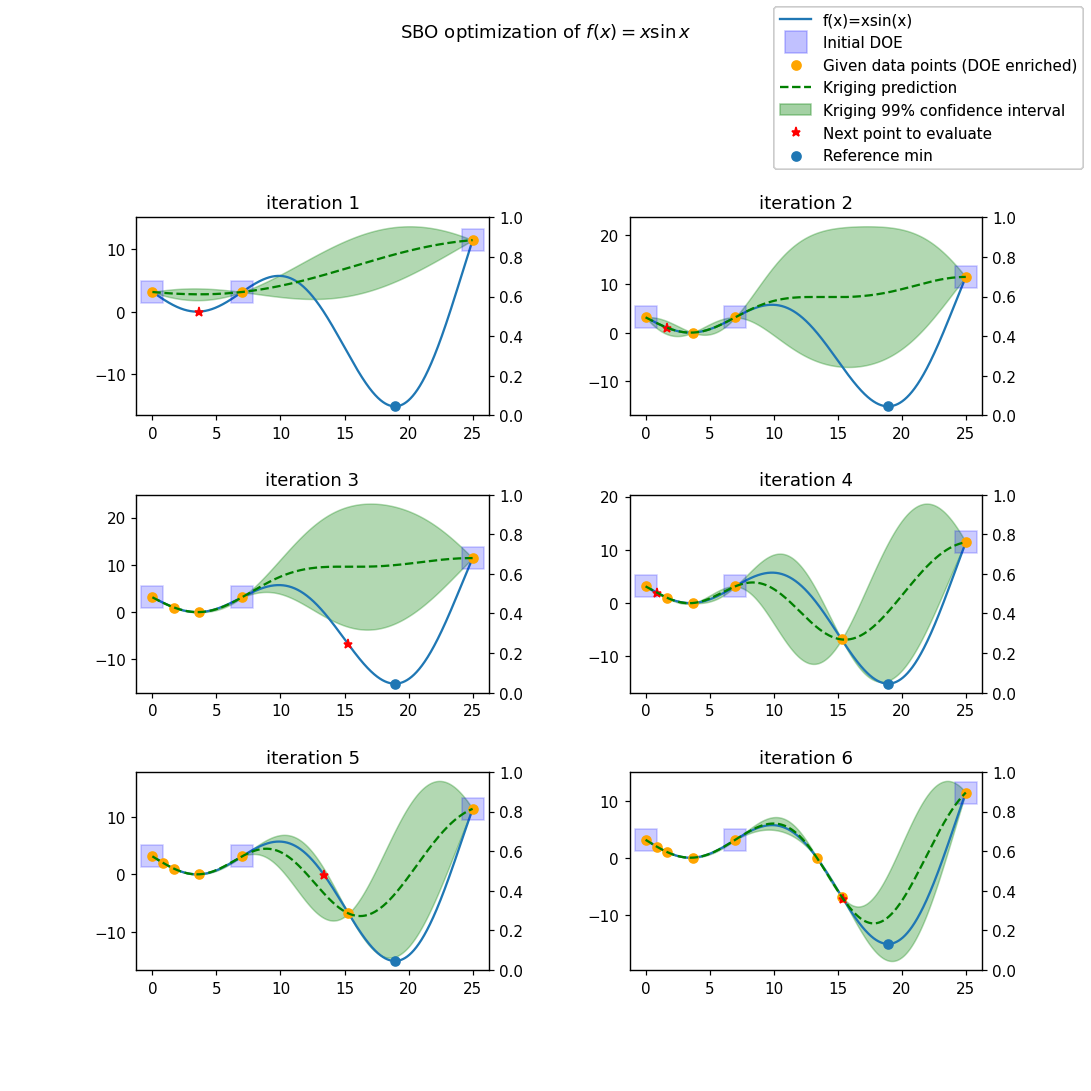

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1528628
x0 for SLSQP 8.627331007736744
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3555554484562703e-06
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Trai

In [18]:
# number of enrichment loops
nloops = 6
bnds = ((0, 25),)
soladapt = []
# initial doe
# initialization
x_data = xdoe
y_data = ydoe

print("Initial DOE", xdoe)
fig = plt.figure(figsize=[10, 10])
for i in range(nloops):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    # create sm for the current doe
    # The variable 'theta0' is a list of length ndim.
    t_i = KRG(theta0=[1e-2] * ndim, print_prediction=False, corr="squar_exp")
    # Training
    t_i.set_training_values(x_data_k, y_data_k)
    t_i.train()

    x0 = (xlimits[0, 1] - xlimits[0, 0]) * np.random.random_sample() + xlimits[0, 0]
    print("x0 for SLSQP", x0)  # we can also do some multistart here
    opt = minimize(
        fun_sm_der,
        x0,
        args=t_i,
        method="SLSQP",
        bounds=bnds,
        jac=fun_sm_der,
        options={"gtol": 1e-6, "disp": True},
    )

    # update the doe (xdoe, ydoe=true_function(xdoe))
    x_et_k = opt.x
    y_et_k = fun_1d(x_et_k)

    y_data = np.atleast_2d(np.append(y_data, y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data, x_et_k)).T

    Y_GP_plot = t_i.predict_values(X_plot)
    Y_GP_plot_var = t_i.predict_variances(X_plot)

    ax = fig.add_subplot((nloops + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()

    (true_fun,) = ax.plot(X_plot, Y_plot)
    (doe,) = ax.plot(
        xdoe, ydoe, linestyle="", marker="s", markersize=14, alpha=0.2, color="blue"
    )
    (data,) = ax.plot(x_data_k, y_data_k, linestyle="", marker="o", color="orange")
    # if i < nloops - 1:
    (opt,) = ax.plot(x_data[k], y_data[k], linestyle="", marker="*", color="r")
    (gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
    sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
    sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    solref = ax.scatter(xref, fref)
    lines = [true_fun, doe, data, gp, un_gp, opt, solref]
    fig.suptitle("SBO optimization of $f(x) = x \\sin{x}$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))

    fig.legend(
        lines,
        [
            "f(x)=xsin(x)",
            "Initial DOE",
            "Given data points (DOE enriched)",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Reference min",
        ],
    )
plt.show()

# result= the best point from the doe
ind_best = np.argmin(y_data)
xbest = x_data[ind_best]
ybest = y_data[ind_best]


print("               ")
print(
    "The adaptive  surrogate model solution is ",
    xbest,
    " obtained with ",
    n_doe + nloops,
    "function evaluations of true function",
)

# Bayesian Optimization 


Bayesian optimization is defined by Jonas Mockus in (Mockus, 1975) as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation that we are aware of is (Kushner, 1962 ; Kushner, 1964). Kushner used Wiener processes for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in (Mockus, 1975). This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO (Jones, 1998).

## Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in (Jones, 1998).

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us denote:
$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$
The Expected Improvement funtion (EI) can be expressed:
$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$
where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the right-hand side of EI expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 
$$
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
$$
where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$) \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

Now we want to optimize this function by using Bayesian Optimization and comparing
- Surrogate Based optimization (SBO)
- Expected Improvement criterion (EI)


In a first step we compute the EI criterion

<IPython.core.display.Javascript object>


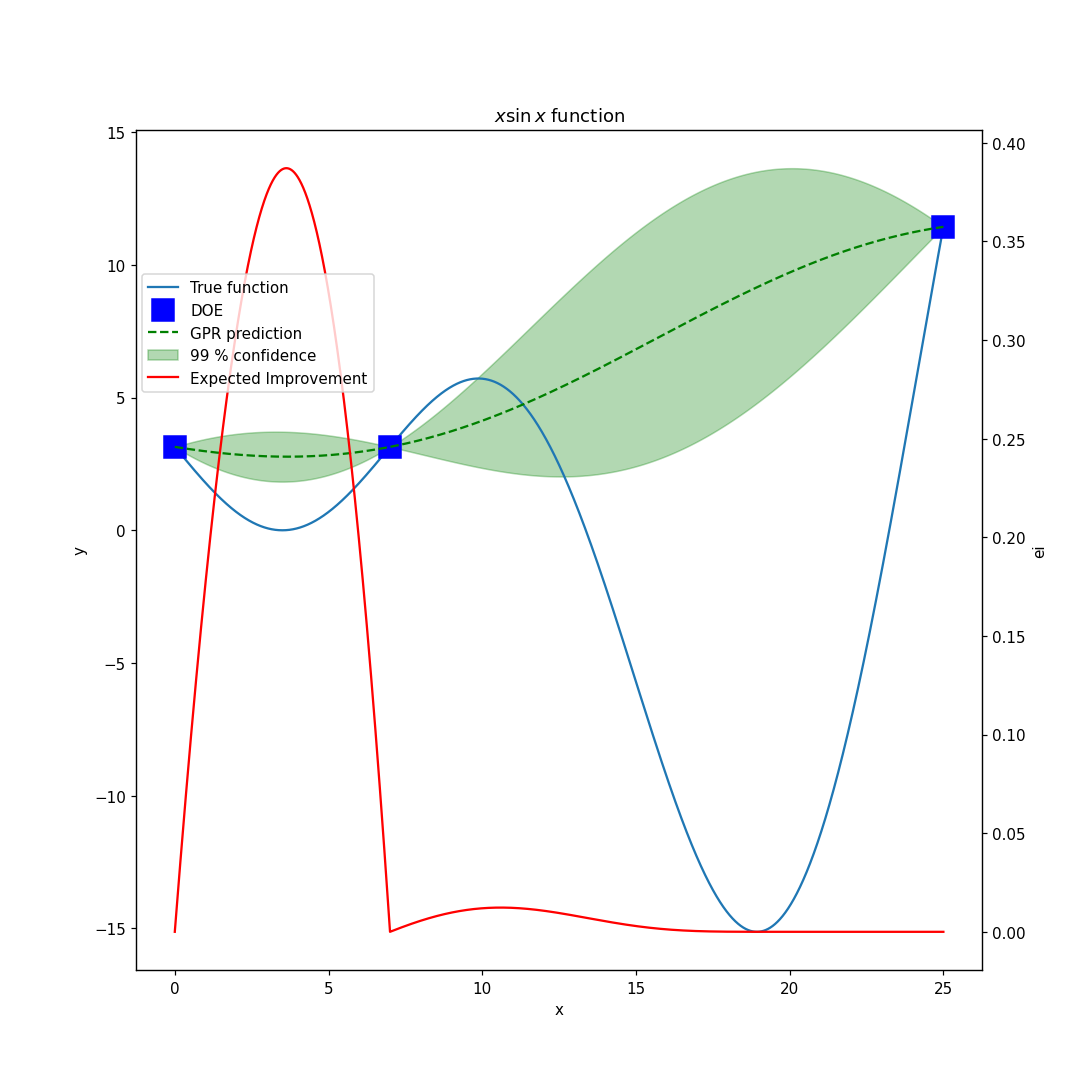

In [19]:
from scipy.stats import norm
from scipy.optimize import minimize


def EI(GP, points, f_min):
    pred = GP.predict_values(points)
    var = GP.predict_variances(points)
    args0 = (f_min - pred) / np.sqrt(var)
    args1 = (f_min - pred) * norm.cdf(args0)
    args2 = np.sqrt(var) * norm.pdf(args0)

    if var.size == 1 and var == 0.0:  # can be use only if one point is computed
        return 0.0

    ei = args1 + args2
    return ei


Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
Y_EI_plot = EI(t, X_plot, np.min(ydoe))

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
ax1 = ax.twinx()
(ei,) = ax1.plot(X_plot, Y_EI_plot, color="red")
lines = [true_fun, doe, gp, un_gp, ei]
ax.set_title(r"$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax1.set_ylabel("ei")
fig.legend(
    lines,
    [
        "True function",
        "DOE",
        "GPR prediction",
        "99 % confidence",
        "Expected Improvement",
    ],
    loc=[0.13, 0.64],
)
plt.show()

Now we compute the EGO method and compare it to other infill criteria 
- SBO (surrogate based optimization): directly using the prediction of the surrogate model ($\mu$)
- LCB (Lower Confidence bound): using the confidence interval : $\mu -3 \times \sigma$
- EI for expected Improvement (EGO)

In [20]:
# surrogate Based optimization: min the Surrogate model by using the mean mu
def SBO(GP, point):
    res = GP.predict_values(point)
    return res


# lower confidence bound optimization: minimize by using mu - 3*sigma
def LCB(GP, point):
    pred = GP.predict_values(point)
    var = GP.predict_variances(point)
    res = pred - 3.0 * np.sqrt(var)
    return res

In [21]:
IC = "EI"

In [22]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML


plt.ioff()


n_iter = 15

gpr = KRG(theta0=[1e-2] * ndim, print_global=False)

# initialization
x_data = xdoe
y_data = ydoe

for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(20) * 25).T
    f_min_k = np.min(y_data)
    gpr.set_training_values(xdoe, ydoe)
    gpr.train()
    if IC == "EI":

        def obj_k(x):
            return -EI(gpr, np.atleast_2d(x), f_min_k)
    elif IC == "SBO":

        def obj_k(x):
            return SBO(gpr, np.atleast_2d(x))
    elif IC == "LCB":

        def obj_k(x):
            return LCB(gpr, np.atleast_2d(x))

    opt_all = np.array(
        [
            minimize(lambda x: float(obj_k(x)), x_st, method="SLSQP", bounds=[(0, 25)])
            for x_st in x_start
        ]
    )
    opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
    obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt["x"]

    y_et_k = fun_1d(x_et_k)

    y_data = np.atleast_2d(np.append(y_data, y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data, x_et_k)).T

    Y_GP_plot = gpr.predict_values(X_plot)
    Y_GP_plot_var = gpr.predict_variances(X_plot)
    Y_EI_plot = -EI(gpr, X_plot, f_min_k)

    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(111)
    if IC == "LCB" or IC == "SBO":
        (ei,) = ax.plot(X_plot, Y_EI_plot, color="red")
    else:
        ax1 = ax.twinx()
        (ei,) = ax1.plot(X_plot, Y_EI_plot, color="red")
    (true_fun,) = ax.plot(X_plot, Y_plot)
    (doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
    (data,) = ax.plot(
        x_data[0 : k + n_doe],
        y_data[0 : k + n_doe],
        linestyle="",
        marker="o",
        color="orange",
    )
    (opt,) = ax.plot(
        x_data[k + n_doe], y_data[k + n_doe], linestyle="", marker="*", color="r"
    )
    (gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
    sig_plus = Y_GP_plot + 3 * np.sqrt(Y_GP_plot_var)
    sig_moins = Y_GP_plot - 3 * np.sqrt(Y_GP_plot_var)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, doe, data, gp, un_gp, opt, ei]
    ax.set_title(r"$x \sin{x}$ function")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(
        lines,
        [
            "True function",
            "initial DOE",
            "Data",
            "GPR prediction",
            "99 % confidence",
            "Next point to Evaluate",
            "Infill Criteria",
        ],
    )
    plt.savefig("Optimisation %d" % k)
    plt.close(fig)

ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print("Results : X = %s, Y = %s" % (x_opt, y_opt))

fig = plt.figure(figsize=[10, 10])

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ims = []
for k in range(n_iter):
    image_pt = mpimg.imread("Optimisation %d.png" % k)
    im = plt.imshow(image_pt)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500)
HTML(ani.to_jshtml())


# Check the optimal point is x_opt=18.9, y_opt =-15.1

Results : X = [16.75895531], Y = [-11.68673177]


 ## Use the EGO from SMT 

In [23]:
from smt.applications.ego import EGO
from smt.utils.design_space import (
    DesignSpace,
)

* Choose your criterion to perform the optimization: EI, SBO or LCB
* Choose the size of the initial DOE
* Choose the number of EGO iterations

Minimum in x=18.9 with f(x)=-15.1


<IPython.core.display.Javascript object>


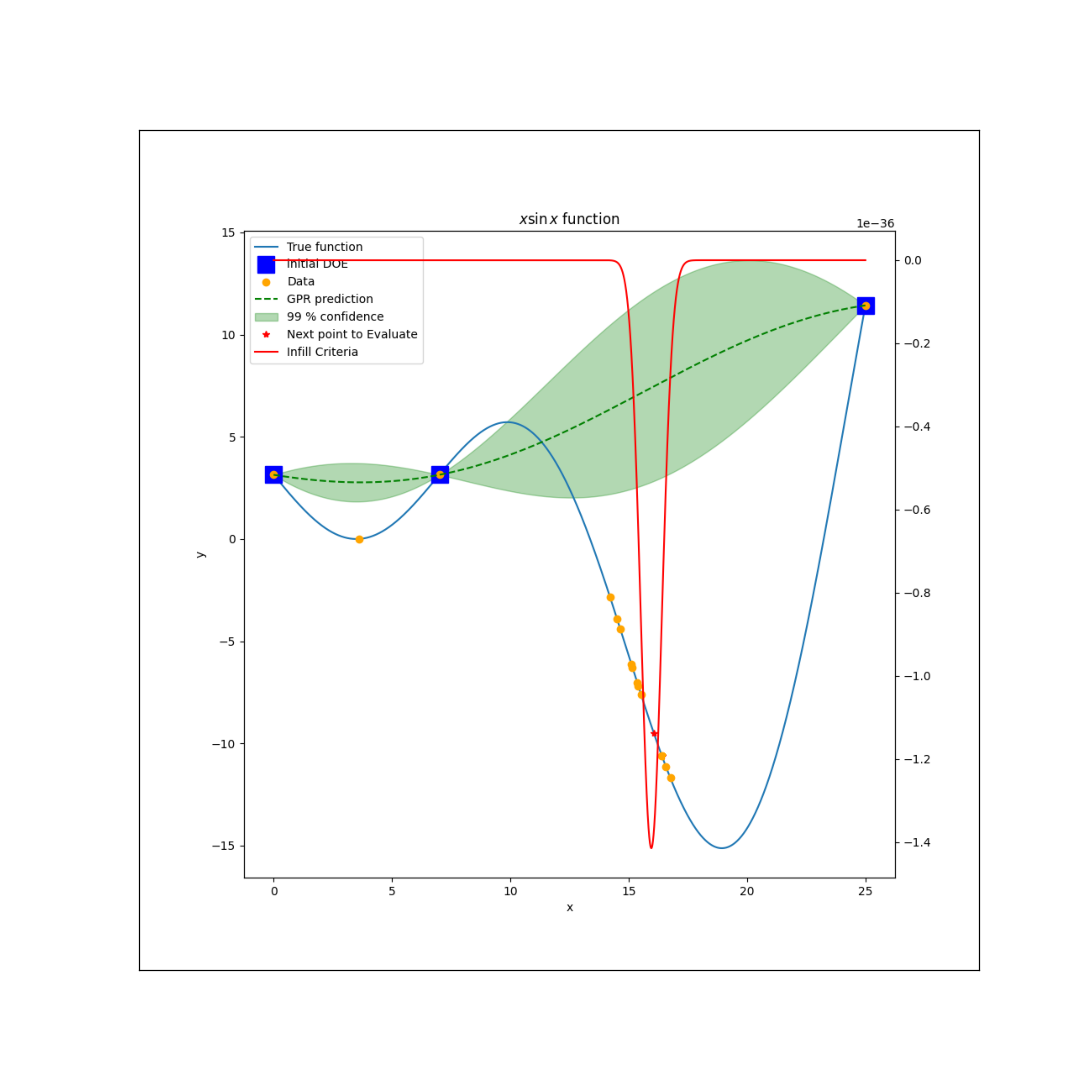

<IPython.core.display.Javascript object>


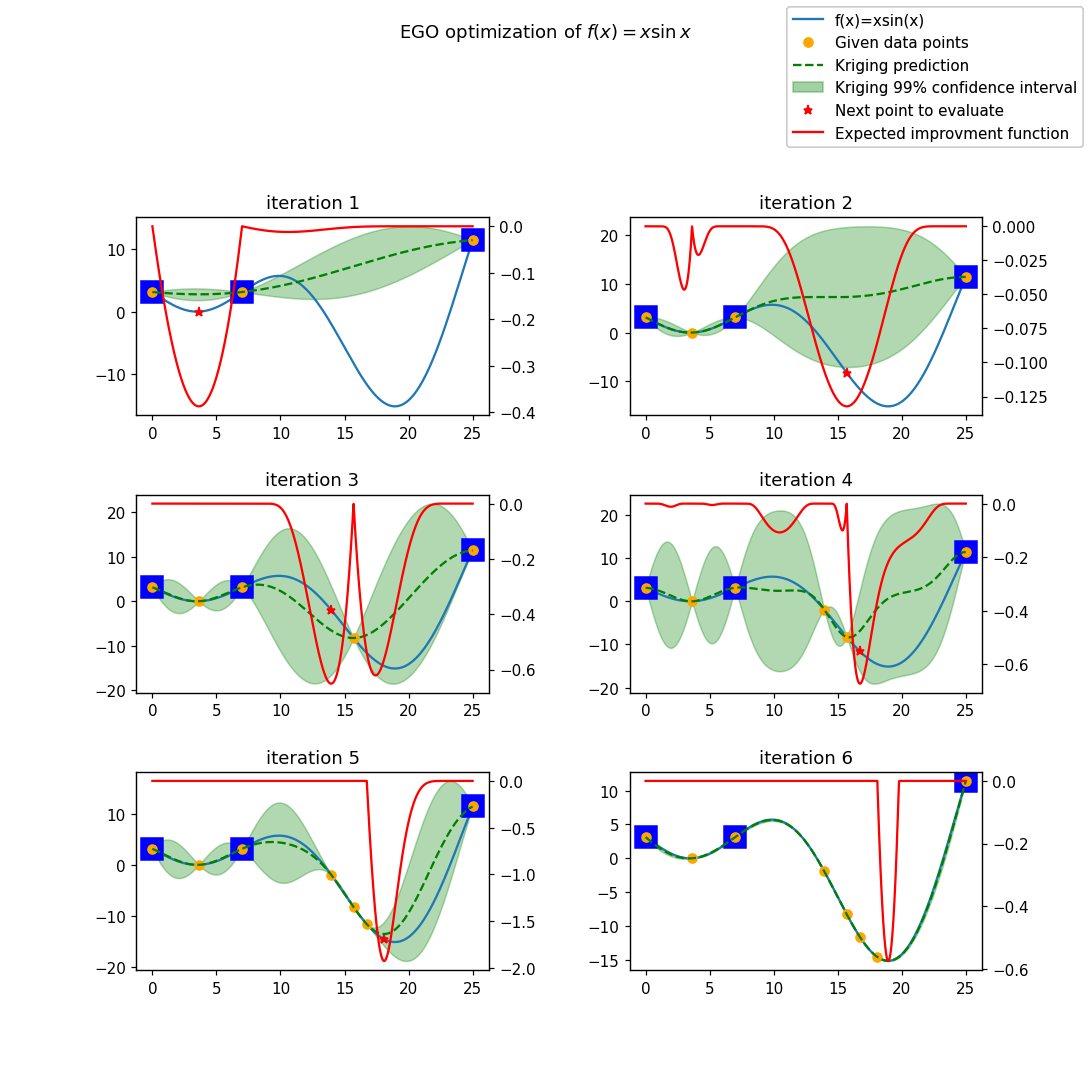

In [24]:
n_iter = 6
xlimits = np.array([[0.0, 25.0]])

random_state = 42  # for reproducibility
design_space = DesignSpace(xlimits, random_state=random_state)


criterion = "EI"  #'EI' or 'SBO' or 'LCB'

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(design_space=design_space, print_global=False),
    random_state=random_state,
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=fun_1d)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(x_opt.item(), y_opt.item()))


fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + i
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    ego.gpr.set_training_values(x_data_k, y_data_k)
    ego.gpr.train()

    y_gp_plot = ego.gpr.predict_values(X_plot)
    y_gp_plot_var = ego.gpr.predict_variances(X_plot)
    y_ei_plot = -ego.EI(X_plot)

    ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
    ax1 = ax.twinx()
    (ei,) = ax1.plot(X_plot, y_ei_plot, color="red")

    (true_fun,) = ax.plot(X_plot, Y_plot)
    (doe,) = ax.plot(xdoe, ydoe, linestyle="", marker="s", markersize=14, color="blue")
    (data,) = ax.plot(x_data_k, y_data_k, linestyle="", marker="o", color="orange")
    if i < n_iter - 1:
        (opt,) = ax.plot(x_data[k], y_data[k], linestyle="", marker="*", color="r")
    (gp,) = ax.plot(X_plot, y_gp_plot, linestyle="--", color="g")
    sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
    sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    lines = [true_fun, data, gp, un_gp, opt, ei]
    fig.suptitle("EGO optimization of $f(x) = x \\sin{x}$")
    fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
    ax.set_title("iteration {}".format(i + 1))
    fig.legend(
        lines,
        [
            "f(x)=xsin(x)",
            "Given data points",
            "Kriging prediction",
            "Kriging 99% confidence interval",
            "Next point to evaluate",
            "Expected improvment function",
        ],
    )
plt.show()
# Check the optimal point is x_opt=18.9, y_opt =-15.1